<h1>Predicting Smoker Status Based on BioSignals</h1>

<h2> Importing Libraries </h2>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
np.linspace(0.1, 0.5, retstep=0.05)

(array([0.1       , 0.10816327, 0.11632653, 0.1244898 , 0.13265306,
        0.14081633, 0.14897959, 0.15714286, 0.16530612, 0.17346939,
        0.18163265, 0.18979592, 0.19795918, 0.20612245, 0.21428571,
        0.22244898, 0.23061224, 0.23877551, 0.24693878, 0.25510204,
        0.26326531, 0.27142857, 0.27959184, 0.2877551 , 0.29591837,
        0.30408163, 0.3122449 , 0.32040816, 0.32857143, 0.33673469,
        0.34489796, 0.35306122, 0.36122449, 0.36938776, 0.37755102,
        0.38571429, 0.39387755, 0.40204082, 0.41020408, 0.41836735,
        0.42653061, 0.43469388, 0.44285714, 0.45102041, 0.45918367,
        0.46734694, 0.4755102 , 0.48367347, 0.49183673, 0.5       ]),
 0.00816326530612245)

<h2> Data Exploration</h2>

In [77]:
df = pd.read_csv('data/train.csv')
df.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [78]:
df.shape

(159256, 24)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   159256 non-null  int64  
 1   age                  159256 non-null  int64  
 2   height(cm)           159256 non-null  int64  
 3   weight(kg)           159256 non-null  int64  
 4   waist(cm)            159256 non-null  float64
 5   eyesight(left)       159256 non-null  float64
 6   eyesight(right)      159256 non-null  float64
 7   hearing(left)        159256 non-null  int64  
 8   hearing(right)       159256 non-null  int64  
 9   systolic             159256 non-null  int64  
 10  relaxation           159256 non-null  int64  
 11  fasting blood sugar  159256 non-null  int64  
 12  Cholesterol          159256 non-null  int64  
 13  triglyceride         159256 non-null  int64  
 14  HDL                  159256 non-null  int64  
 15  LDL              

In [80]:
df.describe()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
count,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,...,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000,159256.000000
mean,79627.500000,44.306626,165.266929,67.143662,83.001990,1.005798,1.000989,1.023974,1.023421,122.503648,...,55.852684,114.607682,14.796965,1.074233,0.892764,25.516853,26.550296,36.216004,0.197996,0.437365
std,45973.391572,11.842286,8.818970,12.586198,8.957937,0.402113,0.392299,0.152969,0.151238,12.729315,...,13.964141,28.158931,1.431213,0.347856,0.179346,9.464882,17.753070,31.204643,0.398490,0.496063
min,0.000000,20.000000,135.000000,30.000000,51.000000,0.100000,0.100000,1.000000,1.000000,77.000000,...,9.000000,1.000000,4.900000,1.000000,0.100000,6.000000,1.000000,2.000000,0.000000,0.000000
25%,39813.750000,40.000000,160.000000,60.000000,77.000000,0.800000,0.800000,1.000000,1.000000,114.000000,...,45.000000,95.000000,13.800000,1.000000,0.800000,20.000000,16.000000,18.000000,0.000000,0.000000
50%,79627.500000,40.000000,165.000000,65.000000,83.000000,1.000000,1.000000,1.000000,1.000000,121.000000,...,54.000000,114.000000,15.000000,1.000000,0.900000,24.000000,22.000000,27.000000,0.000000,0.000000
75%,119441.250000,55.000000,170.000000,75.000000,89.000000,1.200000,1.200000,1.000000,1.000000,130.000000,...,64.000000,133.000000,15.800000,1.000000,1.000000,29.000000,32.000000,44.000000,0.000000,1.000000
max,159255.000000,85.000000,190.000000,130.000000,127.000000,9.900000,9.900000,2.000000,2.000000,213.000000,...,136.000000,1860.000000,21.000000,6.000000,9.900000,778.000000,2914.000000,999.000000,1.000000,1.000000


In [81]:
df.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [82]:
corr_df = df.corr()
corr_df = corr_df.stack().reset_index()
corr_df = corr_df[corr_df.level_1 != corr_df.level_0]
corr_df = corr_df.set_index(["level_0", "level_1"])
corr_df = corr_df[abs(corr_df[0]) >= 0.6]
corr_df

0
level_0     level_1              
height(cm)  weight(kg)   0.686645
weight(kg)  height(cm)   0.686645
            waist(cm)    0.830208
waist(cm)   weight(kg)   0.830208
systolic    relaxation   0.753003
relaxation  systolic     0.753003
Cholesterol LDL          0.808533
LDL         Cholesterol  0.808533
AST         ALT          0.623408
ALT         AST          0.623408

Corelated Features are:
1. Height and weight
2. Waist and weight
3. Systolic and relaxation
4. Cholestrol and LDL
5. AST and ALT

In [83]:
pca_list = ["height(cm)", "weight(kg)", "systolic", "relaxation", "Cholesterol", "LDL", "AST", "ALT"]

<h2> Preprocessing Procedures </h2>

In [84]:
# Splits Data into Features and Target Variable
# args: df
# returns: modified _df 
def split_data(data):
    y = df["smoking"]
    X = data.drop(columns=["smoking", "id"])
    return X,y
#Scales Features within the data using Sklearn Standard Scaler (Maintains Column info)
# args: df
# returns: scaled Dataframe 
def scaler_function(data):
    scl = StandardScaler()
    cols = data.columns
    X = pd.DataFrame(scl.fit_transform(data))
    X.columns = cols
    return X

#Performs PCA on the dataset
# args: data, pca_list(list of features to perfrom PCA on)
#returns: PCAed Dataset

def pca_function(data, feat_list, var_preserved):

    pca_data = data[pca_list]
    data = data.drop(columns=pca_list)

    pca = PCA(n_components=var_preserved)
    fitted_data = pd.DataFrame(pca.fit_transform(pca_data))
    fitted_data = fitted_data.add_prefix("pca_comp_")
     
    return pd.concat([fitted_data, data], axis=1)

In [85]:
def preprocessing(df):
    X,y = split_data(df)
    X = scaler_function(X)
    return X,y

In [86]:
X, y = preprocessing(df)
X.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,0.902985,-0.030268,-0.567581,-0.223489,-1.257856,-1.022156,-0.156725,-0.154865,0.981702,1.125777,...,2.604429,-1.135246,-1.406581,1.189928,-0.213401,0.597927,-0.371570,-0.087326,-0.295342,-0.496866
1,2.169636,-0.030268,-0.170319,0.669577,-1.009169,-0.767247,6.380587,6.457242,1.845852,0.681066,...,-1.097105,0.082162,0.404573,0.980315,-0.213401,1.155511,0.156700,-0.199983,0.025124,2.012614
2,-2.052535,0.536694,0.624205,-0.223489,-1.506543,-1.277064,-0.156725,-0.154865,-0.353802,-0.208355,...,1.048274,-0.777185,-0.767350,1.818767,-0.213401,-0.517239,0.156700,0.250645,0.537870,-0.496866
3,-0.785883,1.670617,2.213252,2.455708,1.229017,0.507296,-0.156725,-0.154865,0.667465,1.236955,...,1.138923,-1.278470,-0.447734,0.770702,-0.213401,0.597927,-0.582878,0.025331,-0.199202,2.012614
4,-1.208100,-0.030268,-0.567581,-0.279305,1.229017,-0.002521,-0.156725,-0.154865,-0.118125,-0.097177,...,-0.613639,-0.848797,-0.767350,0.421347,-0.213401,-0.517239,-0.688532,-0.763267,-0.615808,-0.496866


<h2> Feature Selection </h2>

In [87]:
rf =  RandomForestClassifier()
rf.fit(X, y)

RandomForestClassifier()

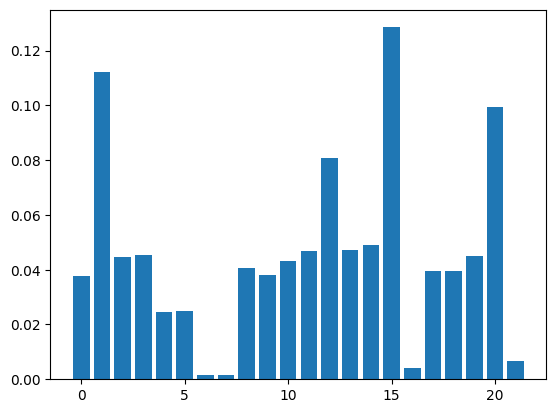

In [88]:
plt.bar([x for x in range(len(rf.feature_importances_))], rf.feature_importances_)
plt.show()

In [89]:
#most important features
X.columns[pd.Series(rf.feature_importances_).nlargest(3).index]

Index(['hemoglobin', 'height(cm)', 'Gtp'], dtype='object')

In [90]:
#least important features
drop_feats = pd.Series(rf.feature_importances_).nsmallest(3)
drop_feats = drop_feats.index
drop_feats

Index([6, 7, 16], dtype='int64')

In [91]:
X = X.drop(columns=X.columns[drop_feats])
X.shape

(159256, 19)

<h2> Model Selection and Evaluation </h2>

In [92]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", np.mean(scores))
    print("Std Dev: ", scores.std())

In [93]:
#Random Forest Model Evaluation 
rf = RandomForestClassifier()
scores = cross_val_score(rf, X, y, scoring='accuracy', cv=10)

In [94]:
display_scores(scores)

Scores:  [0.77527314 0.7709406  0.77891498 0.77213362 0.77558709 0.77389175
 0.7766405  0.77745683 0.78210361 0.76872841]
Mean:  0.7751670534305937
Std Dev:  0.0037404773911770685


In [95]:
#XGB Model Evaluation
clf = xgb.XGBClassifier()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)

In [96]:
display_scores(scores)

Scores:  [0.78192892 0.77740801 0.784001   0.77791034 0.78299636 0.7807359
 0.77965463 0.78549451 0.78568289 0.77814757]
Mean:  0.781396012681099
Std Dev:  0.0029475528696114566


In [97]:
#Logistic Regression Model Evaluation
clf = LogisticRegression()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)

In [98]:
display_scores(scores)

Scores:  [0.74645234 0.74356398 0.74927791 0.74368956 0.75021977 0.74795931
 0.74737834 0.75466248 0.75830455 0.74518053]
Mean:  0.7486688780980953
Std Dev:  0.0044905427708539876


In [99]:
#K-Nearest Neighbors Model Evaluation
clf = KNeighborsClassifier()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)

In [100]:
display_scores(scores)

Scores:  [0.73326636 0.72868266 0.73471054 0.73012684 0.73640588 0.73590355
 0.73029827 0.73934066 0.73343799 0.73155416]
Mean:  0.7333726901361497
Std Dev:  0.0031355799950985113


In [101]:
display_scores(scores)

Scores:  [0.73326636 0.72868266 0.73471054 0.73012684 0.73640588 0.73590355
 0.73029827 0.73934066 0.73343799 0.73155416]
Mean:  0.7333726901361497
Std Dev:  0.0031355799950985113


In [102]:
# Naive Bayes Model Evaluation
clf = GaussianNB()
scores = cross_val_score(clf, X, y, scoring='accuracy', cv=10)

In [103]:
display_scores(scores)

Scores:  [0.72133618 0.71913852 0.72805475 0.72215246 0.72265478 0.72416175
 0.72822606 0.72797488 0.72747253 0.72      ]
Mean:  0.7241171899627614
Std Dev:  0.003376397179576235


<h3> Model Tuning </h3>

I will select these models for my ensemble method:
    1. Logisitic Regression
    2. XGBoost
    3. Guassian NB / KNN (I will tune both and decide)

<b> Log Reg Model Finetuning </b>

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=1)

In [166]:
# Finetuning Logistic Regression
log_reg = LogisticRegression()

param_grid = [
    {"penalty": [None, "l2", "l1","elasticnet"], "solver":["lbfgs", "newton-cholesky", "saga"],
   "max_iter": range(100, 1000, 100), "C": np.linspace(0.1, 1.5, retstep=0.1)}
]
random_search = RandomizedSearchCV(log_reg, param_grid, cv=5, scoring="accuracy", return_train_score=True, n_iter=100)
random_search.fit(X_train,y_train)


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions=[{'C': (array([0.        , 0.03061224, 0.06122449, 0.09183673, 0.12244898,
       0.15306122, 0.18367347, 0.21428571, 0.24489796, 0.2755102 ,
       0.30612245, 0.33673469, 0.36734694, 0.39795918, 0.42857143,
       0.45918367, 0.48979592, 0.52040816, 0.55102041, 0.58163265,
       0.6122449 , 0.64285714, 0.67346939, 0.70408...
       0.91836735, 0.94897959, 0.97959184, 1.01020408, 1.04081633,
       1.07142857, 1.10204082, 1.13265306, 1.16326531, 1.19387755,
       1.2244898 , 1.25510204, 1.28571429, 1.31632653, 1.34693878,
       1.37755102, 1.40816327, 1.43877551, 1.46938776, 1.5       ]),
                                               0.030612244897959183),
                                         'max_iter': range(100, 1000, 100),
                                         'penalty': [None, 'l2', 'l1',
                                                     'elasticnet'],
                                         'solver': ['lbfgs', 'newton-cholesky',
                                                    'saga']}],
                   return_train_score=True, scoring='accuracy')

In [191]:
random_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=225, min_samples_leaf=10)

In [162]:
np.sqrt(-random_search.best_score_)

0.5007487441806315

In [158]:
# Narrowing Down Hyperparameter Search
param_grid = [
    {"penalty": [None, "l2", "l1","elasticnet"], "solver":["newton-cholesky", "saga"],
   "max_iter": range(350, 500, 25), "C": np.linspace(0.1, 0.5, retstep=0.05)}
]

log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(X_train, y_train)

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None wil

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': (array([0.        , 0.01020408, 0.02040816, 0.03061224, 0.04081633,
       0.05102041, 0.06122449, 0.07142857, 0.08163265, 0.09183673,
       0.10204082, 0.1122449 , 0.12244898, 0.13265306, 0.14285714,
       0.15306122, 0.16326531, 0.17346939, 0.18367347, 0.19387755,
       0.20408163, 0.21428571, 0.2244898 , 0.23469388, 0.24489796,
       0.25510204,...
       0.30612245, 0.31632653, 0.32653061, 0.33673469, 0.34693878,
       0.35714286, 0.36734694, 0.37755102, 0.3877551 , 0.39795918,
       0.40816327, 0.41836735, 0.42857143, 0.43877551, 0.44897959,
       0.45918367, 0.46938776, 0.47959184, 0.48979592, 0.5       ]),
                                0.01020408163265306),
                          'max_iter': range(350, 500, 25),
                          'penalty': [None, 'l2', 'l1', 'elasticnet'],
                          'solver': ['newton-cholesky', 'saga']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [190]:
(grid_search.best_estimator_)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

In [164]:
np.sqrt(-grid_search.best_score_)

0.5010496051353799

<b> Random Forest Model Finetuning </b>

In [200]:
rf = RandomForestClassifier()

param_grid = [
    {"n_estimators" : range(1,250, 25), "criterion": ["gini", "entropy", "log_loss"], "max_depth": range(1,250,25), "min_samples_leaf": range(1,50,5)}
]
random_search = RandomizedSearchCV(rf, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_iter=100)
random_search.fit(X_train, y_train)


In [8]:
np.linspace(0,1, num=10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [199]:
random_search.best_params_

{'n_estimators': 101,
 'min_samples_leaf': 11,
 'max_depth': 201,
 'criterion': 'log_loss'}

In [176]:
np.sqrt(-random_search.best_score_)

0.47301202887733246

<b> KNN Model Finetuning </b>

In [189]:
    knn = KNeighborsClassifier()
    param_grid = [
        {"n_neighbors": range(1,100)}
    ]
    grid_search = GridSearchCV(knn,param_grid, cv=5,scoring="accuracy",return_train_score=True)
    grid_search.fit(X_train, y_train)

KeyboardInterrupt: 